# This notebook is a scratch pad to develop the model 

In [19]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from Bio.Data import IUPACData
from collections import defaultdict
from itertools import product, combinations
from scipy.spatial.distance import hamming
import scipy.stats as ss

import sys

sys.path.append("../") 
import doe_utils


# TEST MAKE AMINO ACID WORLD SMALL 

doe_utils.AMINO_ACIDS = doe_utils.AMINO_ACIDS[:4] 
AMINO_ACIDS = doe_utils.AMINO_ACIDS

# For simulation, create a random parent amino acid sequence to create SOLD libraries from

In [2]:
length_of_protein = 100
parent = ''.join(np.random.choice(AMINO_ACIDS, length_of_protein))
print("Parent protein:", parent) 

Parent protein: ADCDEAACDACDEADDCCCCDEAAEECCDAEDEAECEEEDEDDDCACDDDADDCCDCADDEDEECACEAEEAECEDDCAAACDEEDAAAAACAADAACDC


# Need to create a matrix of postion vs letters

In [3]:
num_mutated = 6
mutated_pos = np.sort(np.random.choice(range(length_of_protein), num_mutated, replace = False))
print(mutated_pos) 

[ 7 13 29 53 71 91]


## For every poisiton to mutate choose a few amino acids to mutate to, with parent amino acid at that pos. to be most probable 

In [4]:
random_muts = [] 
parent_prob = 0.85
mut_probs = [0.05, 0.05, 0.05] # I am keeping it simple here 
assert np.sum(mut_probs) + parent_prob == 1

mut_dict = defaultdict(dict) 
for i in mutated_pos: 
    draws = list(AMINO_ACIDS) 
    draws.remove(parent[i]) 
    to_draw = np.random.choice(draws, len(mut_probs), replace = False) 
    mut_dict[int(i)] = {parent[i]: parent_prob} 
    for k,l in enumerate(to_draw):
        mut_dict[int(i)].update({str(l): mut_probs[k]})

In [5]:
# Create mutation matrix 
sold_mat = np.zeros((len(AMINO_ACIDS), length_of_protein))
for k,v in mut_dict.items(): 
    for base, prob in v.items(): 
        sold_mat[AMINO_ACIDS.index(base), k] = prob


sold_mat_df = pd.DataFrame(sold_mat, index = AMINO_ACIDS, columns = np.arange(length_of_protein))
sold_mat_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,...,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.85,0.0,0.0,...,0.0,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,...,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,0.0,0.0,...,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Plot the SOLD matrix 

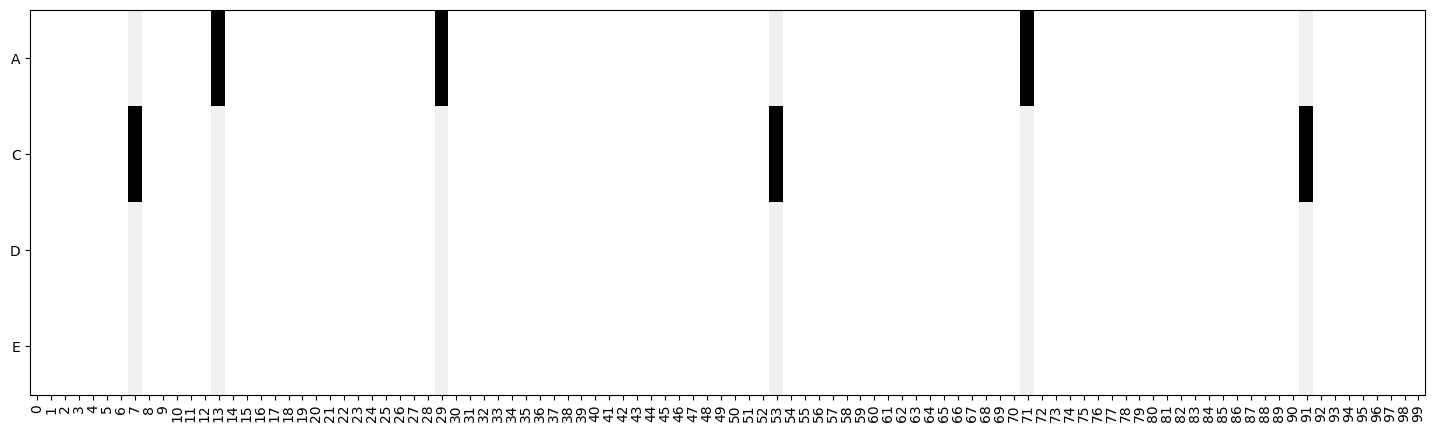

In [6]:
plt.figure(figsize = (18,5))
plt.imshow(sold_mat_df, aspect = 'auto', cmap = 'grey_r') 
_  = plt.xticks(range(length_of_protein), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)


# Now let's try to draw mutated sequences from this matrix 
## Above I have created a simple SOLD mat, but I want to make tools such that everything below will work with any experimentaliat provided SOLD mat

In [7]:
S = doe_utils.SOLD(sold_mat_df)
seqs, mutations = S.generate_sequences(1000)

In [8]:
seqs[0]

'CAACAC'

In [9]:
a= S.compute_prob_n_mutations(num_mutated)

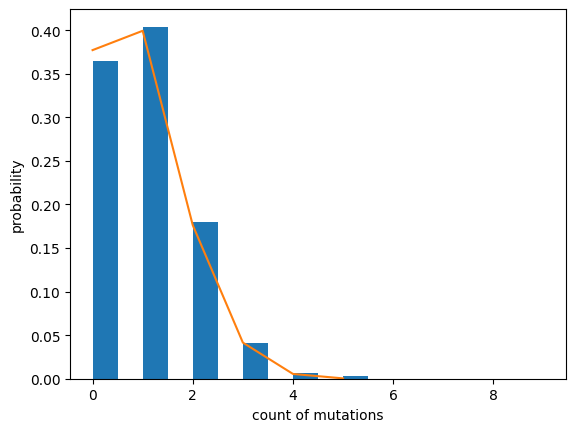

In [10]:
plt.hist(mutations, bins= np.array(range(10)), density = True, align = "mid", width = 0.5) 
plt.ylabel('probability')
plt.xlabel('count of mutations') 
plt.plot(a)

# Test encoding  

In [11]:
# Given a mutational landscape defined by a SOLD matric we want to create a simulator that assigns individual, 
# epistatic and effects 

In [12]:
# Run SOLD mat through the class to get the positions mutated and what muations can be observed 
S.mutation_probs

defaultdict(dict,
            {7: {'A': 0.05, 'C': 0.85, 'D': 0.05, 'E': 0.05},
             13: {'A': 0.85, 'C': 0.05, 'D': 0.05, 'E': 0.05},
             29: {'A': 0.85, 'C': 0.05, 'D': 0.05, 'E': 0.05},
             53: {'A': 0.05, 'C': 0.85, 'D': 0.05, 'E': 0.05},
             71: {'A': 0.85, 'C': 0.05, 'D': 0.05, 'E': 0.05},
             91: {'A': 0.05, 'C': 0.85, 'D': 0.05, 'E': 0.05}})

# Draw individual contribution weights from  mixture of Gaussian --- some of very small effects and some of large effect sizes 

In [97]:
class create_mixture: 
    """
    Generates synthetic approximate "sparse" signal---this simply creates a mixture of distributions, one is close to zero (so, irrelevant and noise, so is Gaussian)
    and the other is any other distribution that is the "relevant" signal 
    Args: 
        rho: sparsity fraction for the postive and negative components of weights 
        sparse_pdf_name: any pdf function from scipy.stats, pass name as string
        noise_sigma: std. of zero centered noise 
        sparse_params: the params for the sparse signal pdf 
        
    Returns: 
        sparse signal pdf method 
        sprase signal rvs method to draw samples 
    """
    def __init__(self, rho = [0.4, 0.2], sparse_pdf_names = ['norm', 'norm'], noise_sigma = 0.02, sparse_params = [{'loc': 0.5, 'scale': 0.2}, {'loc': -0.5, 'scale': 0.2}]): 
        """
        See Args above 
        """
        assert np.sum(rho) < 1, 'No zero component' 
        self.pdf1 = ss.norm(loc = 0, scale = noise_sigma)
        self.pdf2 = getattr(ss, sparse_pdf_names[0])(**sparse_params[0])
        self.pdf3 = getattr(ss, sparse_pdf_names[1])(**sparse_params[1])

        self.rho = rho 
        self.sparse_pdf_name = sparse_pdf_names
        self.noise_sigma = noise_sigma
        self.sparse_params = sparse_params
        
    def pdf(self): 
        """
        pdf(x) --- x is the support you want to evaluate the function on 
        """
        mixture = lambda x: (1-np.sum(self.rho))*self.pdf1.pdf(x) + self.rho[0]*self.pdf2.pdf(x) + self.rho[1]*self.pdf3.pdf(x)
        return mixture 
    
    def samples(self, N): 
        """
        draw N samples 
        """
        ans = np.zeros(N)
        index = np.asarray(random.choices([0,1,2], weights=[1-np.sum(self.rho), self.rho[0], self.rho[1]],k=N))
        size0 = np.sum(index == 0)
        size1 = np.sum(index == 1)
        size2 = np.sum(index == 2)
        print(size0, size1, size2)
        ans[index == 0] = self.pdf1.rvs(size = size0)
        ans[index == 1] = self.pdf2.rvs(size = size1)
        ans[index == 2] = self.pdf3.rvs(size = size2)
        return ans, index         
    





In [80]:
type(index)

list

416 401 183


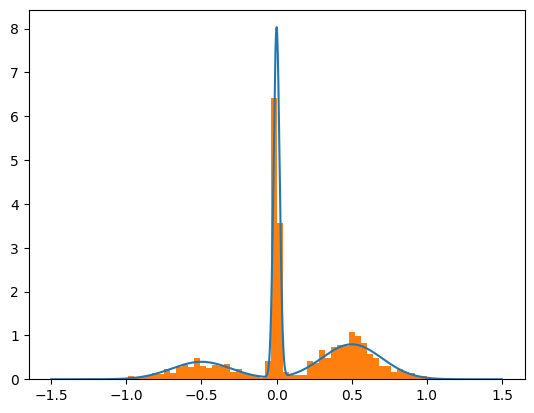

In [98]:
G = create_mixture()
samples, index = G.samples(1000)
x = np.linspace(-1.5, 1.5, 10000)

plt.plot(x, G.pdf()(x))
_ = plt.hist(samples, density=True, bins = 50)

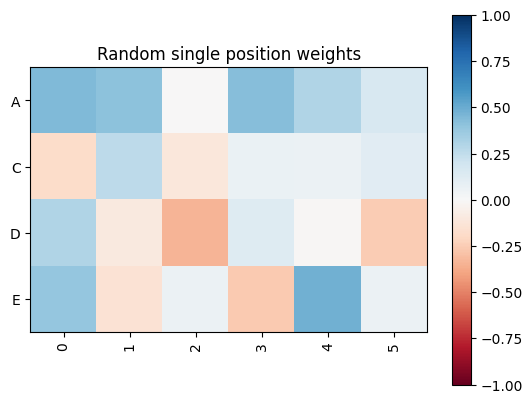

In [13]:
# assign random values (weights) to all individual, pairwise, triplet etc. 



single_weights = np.random.rand(len(AMINO_ACIDS), num_mutated) - 0.5
plt.imshow(single_weights, vmin = -1, vmax = 1, cmap = 'RdBu') 
_  = plt.xticks(range(num_mutated), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)
plt.title("Random single position weights") 
plt.colorbar() 

# Random pairwise contributions / weights

Text(0.5, 1.0, 'Random double position weights')

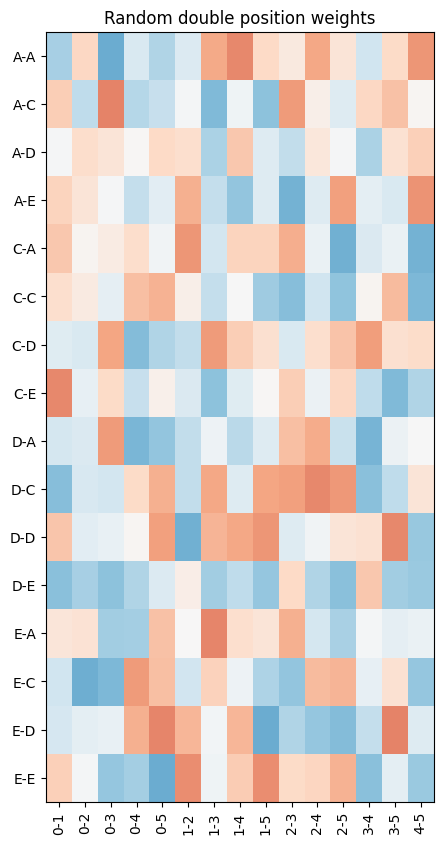

In [14]:
# pairwise mutations 
# We need to consider all possible amino acid combinations for all pariwise positions
amino_product = ['-'.join(list(x)) for x in product(AMINO_ACIDS, AMINO_ACIDS)]
pos_product = ['-'.join(map(str, list(x))) for x in combinations(np.arange(num_mutated), 2)]

plt.figure(figsize = (5, 10))
double_weights = np.random.rand(len(amino_product), len(pos_product)) - 0.5
plt.imshow(double_weights, vmin = -1, vmax = 1, cmap = 'RdBu', aspect = 'auto') 
_  = plt.xticks(range(len(pos_product)), pos_product, rotation = 90)
_  = plt.yticks(range(len(amino_product)), amino_product)
plt.title("Random double position weights") 
#plt.colorbar() 

In [15]:
S = doe_utils.sequence_encoder(num_mutated)
# Encode the first few seqs
N = 3
res = S.encode_seqs(seqs[:N])

# Sanity check encoding 

Text(0.5, 1.0, 'Random double position weights : CAACAC')

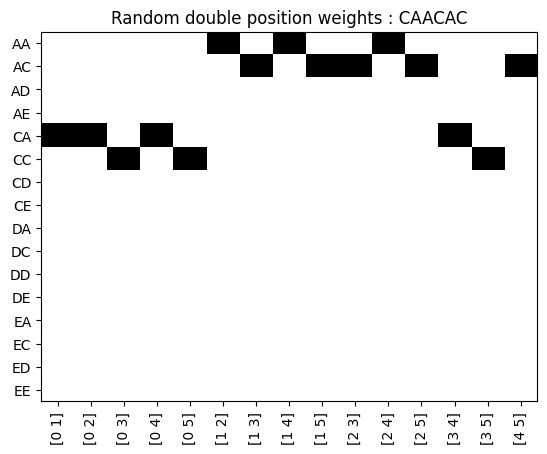

In [16]:
choose_seq = 0 

plt.imshow(res[1][choose_seq], aspect = 'auto', cmap = 'Grays', interpolation= 'None')
_  = plt.xticks(range(len(S.pos_product)), S.pos_product, rotation = 90)
_  = plt.yticks(range(len(S.amino_product)), S.amino_product)
plt.title("Random double position weights : " + seqs[choose_seq]) 





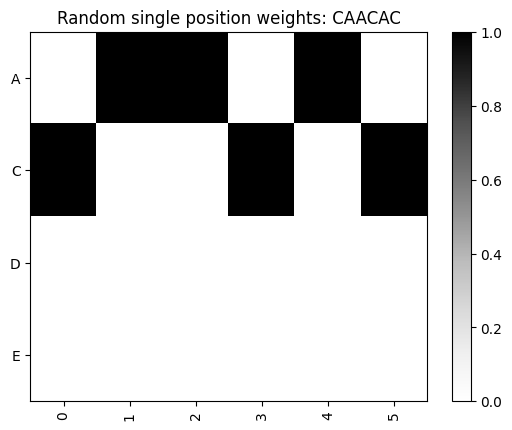

In [17]:
plt.imshow(res[0][choose_seq], aspect = 'auto', cmap = 'Grays', interpolation= 'None') 
_  = plt.xticks(range(num_mutated), rotation = 90)
_  = plt.yticks(range(len(AMINO_ACIDS)), AMINO_ACIDS)
plt.title("Random single position weights: " + str(seqs[0]))  
plt.colorbar() 